In [151]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
from matplotlib import pyplot as plt

from sklearn import metrics, model_selection, preprocessing
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn

from google.colab import drive
drive.mount('/content/drive')
workdir = "/content/drive/My Drive/OrderBookResearch/"

def write_to_csv(filename, array):
  np.savetxt(filename, array, delimiter=",", fmt='%f.3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing

In [152]:
train_df = pd.read_csv(workdir + "train.csv")
test_df = pd.read_csv(workdir + "test.csv")

In [153]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186590 entries, 0 to 186589
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   VASK0       186590 non-null  int64
 1   VASK1       186590 non-null  int64
 2   VASK2       186590 non-null  int64
 3   VASK3       186590 non-null  int64
 4   VASK4       186590 non-null  int64
 5   VBID0       186590 non-null  int64
 6   VBID1       186590 non-null  int64
 7   VBID2       186590 non-null  int64
 8   VBID3       186590 non-null  int64
 9   VBID4       186590 non-null  int64
 10  VASK0_PREV  186590 non-null  int64
 11  VASK1_PREV  186590 non-null  int64
 12  VASK2_PREV  186590 non-null  int64
 13  VASK3_PREV  186590 non-null  int64
 14  VASK4_PREV  186590 non-null  int64
 15  VBID0_PREV  186590 non-null  int64
 16  VBID1_PREV  186590 non-null  int64
 17  VBID2_PREV  186590 non-null  int64
 18  VBID3_PREV  186590 non-null  int64
 19  VBID4_PREV  186590 non-null  int64
 20  Y   

(None, None)

In [154]:
train_df.head()

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,VASK0_PREV,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV,Y
0,108,276,224,196,195,132,181,253,207,185,108,276,224,196,195,136,181,253,207,185,0
1,47,132,197,236,188,81,146,193,169,192,47,132,197,236,188,81,146,193,169,192,0
2,93,172,193,226,232,33,128,168,145,140,93,172,193,226,232,33,128,168,145,140,0
3,62,104,169,188,140,75,165,151,206,105,62,104,169,188,140,81,165,151,206,105,0
4,40,43,87,110,99,11,66,77,155,364,40,43,87,110,99,11,66,77,153,364,0


In [155]:
train_df.describe()

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,VASK0_PREV,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV,Y
count,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000,186590.000000
mean,92.788981,178.840495,204.462640,205.277978,202.079436,92.270245,177.477716,203.058487,202.174195,197.799646,92.823549,178.796431,204.430945,205.273975,202.076333,92.318286,177.438491,203.023479,202.169194,197.795123,0.010258
std,66.491713,62.138222,62.969816,65.644839,67.571850,65.281200,59.409587,58.546985,59.286325,61.265705,66.590938,62.173445,62.981647,65.646947,67.573708,65.376130,59.444964,58.557993,59.289762,61.263966,0.100760
min,1.000000,1.000000,5.000000,1.000000,9.000000,1.000000,1.000000,1.000000,4.000000,3.000000,1.000000,1.000000,5.000000,1.000000,9.000000,1.000000,1.000000,1.000000,4.000000,3.000000,0.000000
25%,41.000000,138.000000,162.000000,161.000000,156.000000,40.000000,137.000000,162.000000,161.000000,156.000000,41.000000,138.000000,162.000000,161.000000,156.000000,40.000000,136.000000,162.000000,161.000000,156.000000,0.000000
50%,83.000000,170.000000,196.000000,194.000000,189.000000,83.000000,170.000000,197.000000,195.000000,188.000000,83.000000,170.000000,196.000000,194.000000,189.000000,83.000000,170.000000,197.000000,195.000000,188.000000,0.000000
75%,131.000000,210.000000,232.000000,234.000000,232.000000,132.000000,211.000000,234.000000,233.000000,228.000000,132.000000,210.000000,232.000000,234.000000,232.000000,132.000000,211.000000,234.000000,233.000000,228.000000,0.000000
max,647.000000,784.000000,666.000000,813.000000,738.000000,593.000000,657.000000,683.000000,687.000000,718.000000,647.000000,784.000000,666.000000,813.000000,738.000000,593.000000,657.000000,683.000000,687.000000,718.000000,1.000000


In [156]:
X = train_df.values[:, :-1].astype(int)
y = train_df.values[:, -1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2)

In [157]:
class DatasetOrders(Dataset):
  def __init__(self, X, y = None, transform = None):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, index):
    assert index < len(self), 'index {} is out of bounds'.format(index)
    X = self.X[index]
    
    if self.transform is not None:
      X = self.transform(X)
    X = torch.tensor(X, dtype=torch.float64)

    # for train loader
    if self.y is not None:
      return X, torch.tensor(self.y[index], dtype=torch.float64)
    
    return X

def SplitToVec(X):
  # split dataset into timeseries vectors
  return np.split(X, 2, axis=-1)

In [158]:
INPUT_SIZE = 10
BATCH_SIZE = 32
logdir = './logs'

In [159]:
train_dataset = DatasetOrders(X_train, y_train, transform=SplitToVec)
val_dataset = DatasetOrders(X_test, y_test, transform=SplitToVec)
test_dataset = DatasetOrders(test_df.values, transform=SplitToVec)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model

In [160]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [161]:
# definition of 
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()

    self.bn = nn.BatchNorm1d(2)
    self.rnn = nn.GRU(
        input_size=input_size,
        hidden_size=hidden_size,
        batch_first=True,
    )
    self.to_logits = nn.Linear(hidden_size, 1)
    self.to_probs = nn.Sigmoid()


  def __call__(self, X, with_hidden=False):
    bn_output = self.bn(X.double())
    rnn_output, hid = self.rnn(bn_output)
    out = self.to_logits(rnn_output[:, -1, :])
    probs = self.to_probs(out[:, 0])

    if with_hidden:
      return probs, hid

    return probs


def train_model(model, loss_fn, opt, train_loader, val_loader, n_epochs=100):
  train_loss_history = [[]]
  test_loss_history = [[]]
  model.to(device)

  for n in range(n_epochs):
    model.train(True)
    for X_train, y_train in train_loader:
      X_train, y_train = X_train.to(device), y_train.to(device)
      opt.zero_grad()
      proba, hid_state = model(X_train, with_hidden=True)
      hid_state = hid_state.detach()
      loss = loss_fn(proba, y_train)
      loss.backward()
      opt.step()
      train_loss_history[-1].append(loss.item())

    model.train(False)
    for X_test, y_test in val_loader:
      with torch.no_grad():
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test)
        test_loss_history[-1].append(loss.item())


    clear_output(True)
    print('EPOCH: ', n)
    print('train loss:', np.mean(train_loss_history, axis=1)[-1])
    print('tesr loss:', np.mean(test_loss_history, axis=1)[-1])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(np.mean(train_loss_history, axis=1), label='train loss')
    plt.plot(np.mean(test_loss_history, axis=1), label='test loss')

    plt.legend()
    plt.show()
    train_loss_history.append([])
    test_loss_history.append([])

EPOCH:  49
train loss: 0.047540202787826245
tesr loss: 0.047253759126390245


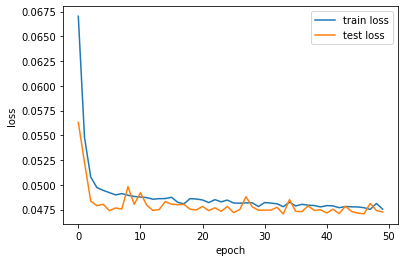

In [162]:
rnn_model = RNN(input_size=INPUT_SIZE, hidden_size=INPUT_SIZE+2).double()
rnn_model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)
loaders = {
    'train' : train_loader,
    'valid' : val_loader
}

train_model(rnn_model, criterion, optimizer,
            train_loader, val_loader, n_epochs=50)

### Model Evaluation

In [163]:
rnn_model.train(False)
rnn_model.to('cpu')

y_pred, y_true = [], []

for X_batch, y_batch in val_loader:
  y_pred = np.concatenate((y_pred, rnn_model(X_batch).tolist()))
  y_true = np.concatenate((y_true, y_batch.tolist()))

In [164]:
print('roc auc score:', metrics.roc_auc_score(y_true, y_pred))

roc auc score: 0.863301523634951
